In [1]:
# All Necessary Imports
## Basic imports
import os
import sys
import gzip
import random
import librosa
import seaborn
import cPickle as pickle

from sklearn.cross_validation import train_test_split

/Users/Steffi/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## Scipy IO imports
from scipy.io.wavfile import read, write
from scipy import signal
from scipy.stats import mode

from IPython.display import Audio

In [3]:
## Other Imports
import pandas as pd
# import colormaps as cmaps   # 'magma', 'inferno', 'plasma', 'viridis', 'parula'
# from utils_dnn import sbuffer, load_labelled
# from utils_dnn import plot_labelled_stft, plot_labelled_wave
# from utils_dnn import plot_confusion_matrix
from tqdm import tqdm
from time import time

In [4]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, GRU, Dropout


Using TensorFlow backend.


In [5]:
seaborn.set(style='ticks')

In [6]:
##################
###  LOAD DATA  ##
##################
# Load Wav File Paths
wavfiles=[]
root='/Users/Steffi/Documents/ENGG177/ClassProject2/free-spoken-digit-dataset-master/recordings/'
exclude = set(['others', 'breath', 'wheeze'])
for path, dirs, files in os.walk(root, topdown=True):
    dirs[:] = [d for d in dirs if d not in exclude]
    for file in files:
        if file.endswith('.wav'):
            wavfiles.append(os.path.join(path, file))

In [7]:
## STFT Computation
nfft = 128
hop  = nfft/2
            
## Duration Distribution
# mu    =  0.32683523
mu    =  0.32
sigma =  0.09912349
# np.random.normal(mu,sigma,1)
## Initialize Variables
Wave     = []
Stft     = []
Class    = []
Filename = []
Duration = []

for wav_file in tqdm(wavfiles):
    # Open audio file
    y, sr = librosa.load(wav_file,sr=16000)

    ## Duration
    dt = librosa.samples_to_time(len(y),sr)
    
    # Normalize by RMSE
    #     rms  = sqrt(mean(square(y)))
    rmse = librosa.feature.rmse(y,hop_length=len(y)+1)[0][0]
    y = y/rmse
    
    ## Compute STFT
    nfft = 128
    hop  = nfft/2
    s = librosa.stft(y,n_fft=nfft-1,hop_length=hop)
    s = librosa.logamplitude(s)

    
    Wave.append(y)
    Stft.append(s)
    Duration.append(dt)
    Class.append(wav_file.split('/')[-1][0])
    Filename.append(wav_file.split('/')[-1])
    
df =      pd.DataFrame({ 'File'    : pd.Series(Filename),
                         'Wave'    : pd.Series(Wave),
                         'Stft'    : pd.Series(Stft),
                         'Duration': pd.Series(Duration),
                         'Class'   : pd.Categorical(Class) })

100%|██████████| 501/501 [00:10<00:00, 48.85it/s]


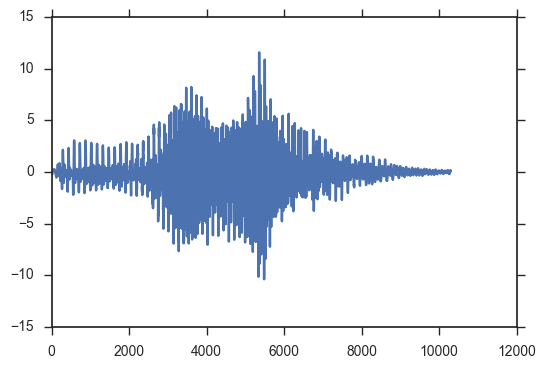

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df.Wave[0])

In [9]:
Audio(data=df.Wave[0],rate=16000)

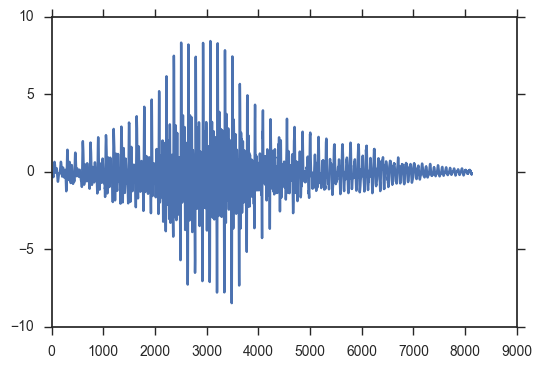

In [10]:
%matplotlib inline
plt.plot(df.Wave[78])

In [11]:
Audio(data=df.Wave[300],rate=16000)

In [12]:
import numpy as np
labels = np.zeros((501,10))
for index, row in df.iterrows():
    labels[index,int(row['Class'])]=1

In [13]:
###########################
###  VISUALIZE DURATION  ##
###########################

## Check Average Duration of classes

import pylab
# figure(1)
# df.groupby('Class').Duration.hist()
# pylab.show()
df0 = df[df.Class=='0']
df1 = df[df.Class=='1']
df2 = df[df.Class=='2']
df3 = df[df.Class=='3']
df4 = df[df.Class=='4']
df5 = df[df.Class=='5']
df6 = df[df.Class=='6']
df7 = df[df.Class=='7']
df8 = df[df.Class=='8']
df9 = df[df.Class=='9']

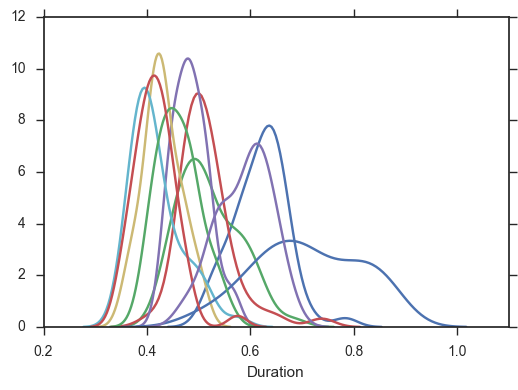

In [14]:
seaborn.distplot(df0.Duration,hist=False)
seaborn.distplot(df1.Duration,hist=False)
seaborn.distplot(df2.Duration,hist=False)
seaborn.distplot(df3.Duration,hist=False)
seaborn.distplot(df4.Duration,hist=False)
seaborn.distplot(df5.Duration,hist=False)
seaborn.distplot(df6.Duration,hist=False)
seaborn.distplot(df7.Duration,hist=False)
seaborn.distplot(df8.Duration,hist=False)
seaborn.distplot(df9.Duration,hist=False)
pylab.show()

In [15]:
byClass = df.groupby('Class')
byClass.Duration.describe()

Class        
0      count             50
       unique            50
       top         [0.6315]
       freq               1
1      count             50
       unique            49
       top        [0.49775]
       freq               2
2      count             50
       unique            50
       top         [0.4655]
       freq               1
3      count             50
       unique            48
       top       [0.521875]
       freq               2
4      count             50
       unique            50
       top         [0.4545]
       freq               1
5      count             50
       unique            49
       top        [0.36775]
       freq               2
6      count             51
       unique            51
       top       [0.677125]
       freq               1
7      count             50
       unique            49
       top         [0.5135]
       freq               2
8      count             50
       unique            48
       top       [0.422375]
      

In [16]:
table = df["Stft"] 

In [17]:
data = table.values
# data = np.hstack(data[:])

In [18]:
maxlen = np.max(map(np.shape,data),axis=0)[1]

In [19]:
d = []
for j in range(len(data)):
    d.append(data[j])

In [20]:
table[0].shape
nTable = np.asarray([item.T for item in table]).reshape(501,1)
# batch_size=1

# # Split the data into   70% and test 30%
train_x,test_x,train_y,test_y = train_test_split(nTable,labels,test_size = 0.3)
# # train_x.shape
nTable.shape
train_x[0].shape

(1,)

In [21]:
def padData(dataa):
    data=[]
    for item in dataa:
        newitem = sequence.pad_sequences(item,maxlen=maxlen)
        data.append(newitem)
    return data
data = padData(nTable)
nntable = np.array(data).squeeze()
data = padData(train_x)
train_x = np.array(data).squeeze()
data = padData(test_x)
test_x = np.array(data).squeeze()

In [22]:
test_x.shape

(151, 220, 64)

In [23]:
train_x.shape

(350, 220, 64)

In [24]:
# Define batch size
batch_size=5

In [ ]:
# Define model
print("Build model...")
model = Sequential()
# model.add(GRU(20,input_shape=(220,64), return_sequences='True'))
# model.add(Dropout(0.5))
model.add(LSTM(20,input_shape=(220,64)))
model.add(Dense(10))
model.add(Activation('relu'))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

Build model...


In [ ]:
print('Train...')
log = model.fit(train_x,train_y,batch_size=batch_size,nb_epoch=20)

Train...
Epoch 1/20
350/350 [==============================] - 62s - loss: 1.0971 - acc: 0.8843      

In [ ]:
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)
loss = log.history['loss']
accuracy = log.history['accuracy'] 

In [ ]:
plt.plot(loss)
plt.show()

In [ ]:
trainPredict[0].shape

In [ ]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
testScore = np.sqrt(mean_squared_error(test_y[0], testPredict[0]))

In [ ]:
print('Train Score: %.2f RMSE\nTest Score: %.2f RMSE' % (trainScore, testScore))

In [ ]:
model.evaluate(testx, testy, batch_size=20, verbose=1, sample_weight=None)